In [22]:
import spacy
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from luima_sbd.sbd_utils import text2sentences
from spacy.symbols import ORTH
from seg.newline.segmenter import NewLineSegmenter
import re
from spacy.tokenizer import Tokenizer
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import fasttext
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import pickle

## Phase 1 - Dataset Splitting

In [2]:
# load labeled corpus
corpus_path = "../corpus/ldsi_w21_curated_annotations_v2.json"
with open(corpus_path) as f:
    corpus = json.load(f)
    
documents = corpus['documents']
annotations = corpus['annotations']
types = corpus['types']


In [3]:
annotated_doc_ids = []
annotated_docs = []

# gather annotated documents' IDs
for annotation in annotations:
    annotated_doc_ids.append(annotation['document'])

# remove duplicate document IDs
annotated_doc_ids = list(set(annotated_doc_ids))

for document in documents:
    for id in annotated_doc_ids:
        if(document['_id'] == id):
            annotated_docs.append(document)
            break

granted_docs = annotated_docs[0:70]
denied_docs = annotated_docs[70:141]

# combine documents with annotations
for doc in granted_docs:
    doc['annotation'] = []
    for annotation in annotations:
        if(annotation['document'] == doc['_id']):
            doc['annotation'].append(annotation)
            
for doc in denied_docs:
    doc['annotation'] = []
    for annotation in annotations:
        if(annotation['document'] == doc['_id']):
            doc['annotation'].append(annotation)

In [4]:
# split dataset
granted, granted_test = train_test_split(granted_docs, test_size=7, random_state=1)
denied, denied_test = train_test_split(denied_docs, test_size=7, random_state=1)
granted_train, granted_dev = train_test_split(granted, test_size=7, random_state=1)
denied_train, denied_dev = train_test_split(denied, test_size=7, random_state=1)

train_set = granted_train + denied_train
test_set = granted_test + denied_test
dev_set = granted_dev + denied_dev

In [5]:
# split dataset
granted, granted_test = train_test_split(granted_docs, test_size=7, random_state=1)
denied, denied_test = train_test_split(denied_docs, test_size=7, random_state=1)
granted_train, granted_dev = train_test_split(granted, test_size=7, random_state=1)
denied_train, denied_dev = train_test_split(denied, test_size=7, random_state=1)

train_set = granted_train + denied_train
test_set = granted_test + denied_test
dev_set = granted_dev + denied_dev

In [6]:
print("Dev documents IDs:")
print([d['_id'] for d in dev_set])
print()
print("Test documents IDs:")
print([d['_id'] for d in test_set])

Dev documents IDs:
['61aea55e97ad59b4cfc412f0', '61aea55d97ad59b4cfc412c7', '61aea55d97ad59b4cfc412cd', '61aea55d97ad59b4cfc412b7', '61aea55c97ad59b4cfc412aa', '61aea55e97ad59b4cfc412d8', '61aea55c97ad59b4cfc412a4', '61aea57397ad59b4cfc41399', '61aea57197ad59b4cfc4136b', '61aea56f97ad59b4cfc4134c', '61aea57097ad59b4cfc41364', '61aea57397ad59b4cfc4139c', '61aea57297ad59b4cfc41380', '61aea57097ad59b4cfc41355']

Test documents IDs:
['61aea55f97ad59b4cfc41334', '61aea55d97ad59b4cfc412d2', '61aea55f97ad59b4cfc41337', '61aea55f97ad59b4cfc41319', '61aea55d97ad59b4cfc412d3', '61aea55f97ad59b4cfc41328', '61aea55f97ad59b4cfc41308', '61aea57497ad59b4cfc413e3', '61aea57197ad59b4cfc41375', '61aea57497ad59b4cfc413e7', '61aea57497ad59b4cfc413c0', '61aea57197ad59b4cfc41376', '61aea57497ad59b4cfc413d8', '61aea57497ad59b4cfc413b3']


## Phase 2 - Deciding on a Sentence Segmenter

In [44]:
nlp = spacy.load("en_core_web_sm")

In [553]:
# calculate the number of false_positives and true_positives for sentence segmentation
def cal_positives(true_set, seg_set):
    false_positives = 0
    true_positives = 0  

    for true_doc in true_set:
        for seg_doc in seg_set:
            if(seg_doc['doc_id'] == true_doc['_id']):
                for start in seg_doc['starts']:
                    for i in range(len(true_doc['annotation'])):
                        if abs(start-true_doc['annotation'][i]['start'])<=3:
                            true_positives+=1
                            break;
                            
                        if i == len(true_doc['annotation'])-1:false_positives+=1

    return false_positives, true_positives

# calculate the number of false_negatives and true_negatives for sentence segmentation
def cal_negatives(true_set, seg_set):
    false_negatives = 0
    true_negatives = 0
  
    for seg_doc in seg_set:
        for true_doc in true_set:
            if(true_doc['_id'] == seg_doc['doc_id']):
                for a in true_doc['annotation']:
                    true_start = a['start'] 
                    for i in range(len(seg_doc['starts'])):
                        if abs(seg_doc['starts'][i]-true_start)<=3:
                            true_negatives+=1
                            break;
                            
                        if i == len(seg_doc['starts'])-1:false_negatives+=1

    return false_negatives, true_negatives

# use spacy to segment sentences of labeled dataset
def spacy_sentencize_labeled(data_set):
    segmentations = []

    for d in data_set:
        doc = nlp(d['plainText'])
        sentences = []
        starts = []

        for sent in doc.sents:
            sentences.append(sent)
            starts.append(sent.start_char)
        
        segmentations.append({
                'doc_id':d['_id'],
                'sentences': sentences,
                'starts': starts
                })

    return segmentations


In [554]:
# Apply the standard English sentence segmenter in spaCy on the training set
spacy_train_segmentations = spacy_sentencize_labeled(train_set)

In [556]:
# calculate false positives and true positives
false_positives, true_positives = cal_positives(train_set, spacy_train_segmentations)
false_negatives, true_negatives = cal_negatives(train_set, spacy_train_segmentations)

print("false positives:",false_positives)
print("true positives:",true_positives)
print("false negatives:",false_negatives)
print("true positives:",true_negatives)

false positives: 5085
true positives: 7696
false negatives: 4718
true positives: 7667


In [557]:
spacy_segmentation_precision = true_positives/(true_positives+false_positives)
spacy_segmentation_recall = true_positives/(true_positives+false_negatives)
spacy_segmentation_f1 = 2*true_positives/(2*true_positives+false_positives+false_negatives)

print("precision of spacy standard segmentation:",spacy_segmentation_precision)
print("recall of spacy standard segmentation:",spacy_segmentation_recall)
print("f1 of spacy standard segmentation:",spacy_segmentation_f1)

precision of spacy standard segmentation: 0.602143807213833
recall of spacy standard segmentation: 0.61994522313517
f1 of spacy standard segmentation: 0.6109148640603295


In [1238]:
# examine three documents after sentence segmentation
exam_seg = [doc['sentences'] for doc in random.sample(spacy_train_segmentations,3)]

In [1290]:
for t in exam_seg:
    for s in t:
        print(s)
        print('--------------------------------Segmentation Line------------------------------------')

Citation Nr: 1615107	
Decision Date: 04/13/16    Archive Date: 04/26/16

DOCKET NO.
--------------------------------Segmentation Line------------------------------------
 12-17 771	)	DATE
	)
	)

On appeal from the
Department of Veterans Affairs Regional Office in Portland, Oregon


THE ISSUE

Entitlement to service connection for bilateral hammertoes, to include as secondary to pes planus and metatarsalgia.
--------------------------------Segmentation Line------------------------------------



REPRESENTATION

Appellant represented by:	Oregon Department of Veterans' Affairs


ATTORNEY FOR THE BOARD

Christopher M. Collins, Associate Counsel






INTRODUCTION


--------------------------------Segmentation Line------------------------------------
The Veteran served on active duty from June 1958 to May 1961 and from December 1961 to August 1962.
--------------------------------Segmentation Line------------------------------------
 This matter is before the Board of Veterans' Appeals (Boa

### Improve spacy segmentation

In [45]:
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case('NO.', [{ORTH: 'NO.'}])

config = {"punct_chars": ['.','\r\n\r\n','\r\n\r\n\r\n']}
nlp.add_pipe("sentencizer", config=config)

# refresh sentenization function
def spacy_sentencize_labeled(data_set):
    segmentations = []

    for d in data_set:
        doc = nlp(d['plainText'])
        sentences = []
        starts = []

        for sent in doc.sents:
            sentences.append(sent)
            starts.append(sent.start_char)
        
        segmentations.append({
                'doc_id':d['_id'],
                'sentences': sentences,
                'starts': starts
                })

    return segmentations


In [1303]:
# Apply the standard English sentence segmenter in spaCy on the training set documents
improved_train_segmentations = spacy_sentencize_labeled(train_set)


In [1304]:
# calculate false positives and true positives
false_positives, true_positives = cal_positives(train_set, improved_train_segmentations)
false_negatives, true_negatives = cal_negatives(train_set, improved_train_segmentations)

print("false positives:",false_positives)
print("true positives:",true_positives)
print("false negatives:",false_negatives)
print("true positives:",true_negatives)

false positives: 2548
true positives: 11050
false negatives: 1436
true positives: 10949


In [1305]:
improved_segmentation_precision = true_positives/(true_positives+false_positives)
improved_segmentation_recall = true_positives/(true_positives+false_negatives)
improved_segmentation_f1 = 2*true_positives/(2*true_positives+false_positives+false_negatives)

print("precision of improved spacy standard segmentation:",improved_segmentation_precision)
print("recall of improved spacy standard segmentation:",improved_segmentation_recall)
print("f1 of improved spacy standard segmentation:",improved_segmentation_f1)


precision of improved spacy standard segmentation: 0.8126195028680688
recall of improved spacy standard segmentation: 0.8849911901329489
f1 of improved spacy standard segmentation: 0.8472626897715074


In [1310]:
# examine three documents after sentence segmentation
exam_improved_seg = [doc['sentences'] for doc in random.sample(improved_train_segmentations,3)]

In [1311]:
for t in exam_improved_seg:
    for s in t:
        print(s)
        print('--------------------------------Segmentation Line------------------------------------')

Citation Nr: 0740298	
Decision Date: 12/21/07    Archive Date: 01/02/08


--------------------------------Segmentation Line------------------------------------
DOCKET NO.  05-29 953	)	DATE
	)
	)


--------------------------------Segmentation Line------------------------------------
On appeal from the
Department of Veterans Affairs Regional Office in 
Philadelphia, Pennsylvania



--------------------------------Segmentation Line------------------------------------
THE ISSUE


--------------------------------Segmentation Line------------------------------------
Entitlement to service connection for a psychiatric disorder, 
to include post traumatic stress disorder (PTSD).



--------------------------------Segmentation Line------------------------------------
REPRESENTATION


--------------------------------Segmentation Line------------------------------------
Appellant represented by:	Disabled American Veterans



--------------------------------Segmentation Line-----------------------

### Law-specific sentence segmenter

In [562]:
# use luima sentencizer to segment training dataset
law_train_segmentations = []

for train_doc in train_set:
    doc_id = train_doc['_id']
    sentences = text2sentences(train_doc['plainText'], offsets=False)
    starts = [start for (start,end) in text2sentences(train_doc['plainText'], offsets=True)]
    
    law_train_segmentations.append({
        'doc_id': doc_id,
        'sentences': sentences,
        'starts': starts
    })
    

In [563]:
# calculate false positives and true positives
false_positives, true_positives = cal_positives(train_set, law_train_segmentations)
false_negatives, true_negatives = cal_negatives(train_set, law_train_segmentations)

print("false positives:",false_positives)
print("true positives:",true_positives)
print("false negatives:",false_negatives)
print("true positives:",true_negatives)

false positives: 2491
true positives: 12288
false negatives: 130
true positives: 12255


In [570]:
luima_segmentation_precision = true_positives/(true_positives+false_positives)
luima_segmentation_recall = true_positives/(true_positives+false_negatives)
luima_segmentation_f1 = 2*true_positives/(2*true_positives+false_positives+false_negatives)

print("precision of luima segmentation:",luima_segmentation_precision)
print("recall of luima segmentation:",luima_segmentation_recall)
print("f1 of luima segmentation:",luima_segmentation_f1)

precision of luima segmentation: 0.8314500304486095
recall of luima segmentation: 0.9895313254952488
f1 of luima segmentation: 0.9036290767364048


In [1315]:
# examine three documents after sentence segmentation
exam_luima_seg = [doc['sentences'] for doc in random.sample(law_train_segmentations,3)]

In [1316]:
for t in exam_luima_seg:
    for s in t:
        print(s)
        print('--------------------------------Segmentation Line------------------------------------')

Citation Nr: 1538335
--------------------------------Segmentation Line------------------------------------
Decision Date: 09/08/15
--------------------------------Segmentation Line------------------------------------
Archive Date: 09/18/15
--------------------------------Segmentation Line------------------------------------
DOCKET NO.  06-05 125
--------------------------------Segmentation Line------------------------------------
DATE
--------------------------------Segmentation Line------------------------------------
On appeal from the
Department of Veterans Affairs Regional Office in Houston, Texas
--------------------------------Segmentation Line------------------------------------
THE ISSUE
--------------------------------Segmentation Line------------------------------------
Entitlement to service connection for a low back disability with sciatica.
--------------------------------Segmentation Line------------------------------------
REPRESENTATION
--------------------------------S

## Phase 3: Preprocessing

In [572]:
# function to get names of all unlabeled decisions
def file_name_listdir(file_dir):
    unlabeled_files = []
    for file in os.listdir(file_dir):  
        unlabeled_files.append(file)

    return unlabeled_files


In [573]:
unlabeled_files = file_name_listdir("../corpus/unlabeled")

In [575]:
# get all texts from unlabeled docs
unlabeled_docs = []

for filepath in unlabeled_files:
    with open("../corpus/unlabeled/"+filepath,'rb') as f:
        unlabeled_docs.append(f.read())
    

In [590]:
# segment all documents of unlabeled docs
sengemented_unlabeleds = []

for doc in unlabeled_docs:
    sentences = text2sentences(str(doc,'latin1'), offsets=False)
    starts = text2sentences(str(doc,'latin1'), offsets=True)
    sengemented_unlabeleds.append({
        'sentences':sentences,
        'starts': starts
    })

Total number of sentences: 3488106


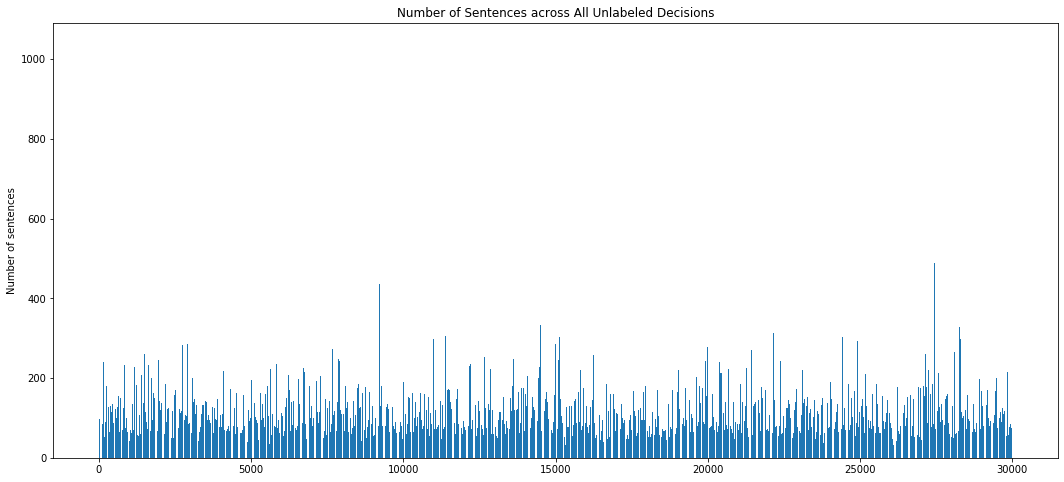

In [810]:
# calculate the total number of sentences and produce a histogram for the number of sentences across all unlabeled decisions
total_sent_num = 0
single_sent_num = []

for s in sengemented_unlabeleds:
    total_sent_num += len(s['sentences'])
    single_sent_num.append(len(s['sentences']))
    
print("Total number of sentences:", total_sent_num)
plt.figure(figsize=(18, 8))
plt.title("Number of Sentences across All Unlabeled Decisions") 
plt.ylabel("Number of sentences") 
# plt.ylim(0, 400)
plt.bar(range(len(single_sent_num)), single_sent_num)
plt.show()

In [737]:
print("minimum number of sentences:",np.array(single_sent_num).min())
print("maximum number of sentences:",np.array(single_sent_num).max())
print("average number of sentences:",np.array(single_sent_num).mean())

minimum number of sentences: 20
maximum number of sentences: 1039
average number of sentences: 116.2702


In [42]:
# tokenization function: referencing the function "spacy_tokenize" in the classifier workshop code
def spacy_tokenize(doc):
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.text == "-":
            pass
        elif re.match("^\s+$", t.text, flags=0) != None:
            pass
        elif t.text == '\r\n':
            pass
        elif t.text == '\t':
            pass    
        elif t.text == "'" or t.text == "'s":
            pass
        elif t.text == '/':
            pass
        elif re.match("^[0-9]\.[0-9]+\([a-z]$", t.text, flags=0) != None:
            clean_tokens.append('<NUM>')
        elif re.match("^[0-9]+[A-Z]", t.text, flags=0):
            clean_tokens.append('<NUM>')
        elif t.pos_ == 'NUM':
            clean_tokens.append('<NUM>')
        else:
            clean_tokens.append(t.lemma_.lower())
    return clean_tokens

In [1319]:
# Test tokenizer 
test_case1 = random.choice(random.choice(sengemented_unlabeleds)['sentences'])
test_case2 = random.choice(random.choice(sengemented_unlabeleds)['sentences'])
test_case3 = random.choice(random.choice(sengemented_unlabeleds)['sentences'])
test_case4 = random.choice(random.choice(sengemented_unlabeleds)['sentences'])
test_case5 = random.choice(random.choice(sengemented_unlabeleds)['sentences'])

print("Test case1:")
print("Original sentence:",test_case1)
print("Segmented result:",spacy_tokenize(nlp(test_case1)))
print("-------------------------------------------------------------------------------------------------------------------")
print("Test case2:")
print("Original sentence:",test_case2)
print("Segmented result:",spacy_tokenize(nlp(test_case2)))
print("-------------------------------------------------------------------------------------------------------------------")
print("Test case3:")
print("Original sentence:",test_case3)
print("Segmented result:",spacy_tokenize(nlp(test_case3)))
print("-------------------------------------------------------------------------------------------------------------------")
print("Test case4:")
print("Original sentence:",test_case4)
print("Segmented result:",spacy_tokenize(nlp(test_case4)))
print("-------------------------------------------------------------------------------------------------------------------")
print("Test case5:")
print("Original sentence:",test_case5)
print("Segmented result:",spacy_tokenize(nlp(test_case5)))
print("-------------------------------------------------------------------------------------------------------------------")

Test case1:
Original sentence: Pursuant to a liberalizing rule promulgated after the Board issued its decision in March 2010, if a stressor claimed by a veteran is related to the veteran's fear of hostile military or terrorist activity and a VA psychiatrist or psychologist, or a psychiatrist or psychologist with whom VA has contracted, confirms that the claimed stressor is adequate to support a diagnosis of PTSD and that the veteran's symptoms are related to the claimed stressor, in the absence of clear and convincing evidence to the contrary, and provided the claimed stressor is consistent with the places, types, and circumstances of the veteran's service, the veteran's lay testimony alone may establish the occurrence of the claimed in-service stressor.
Segmented result: ['pursuant', 'to', 'a', 'liberalizing', 'rule', 'promulgate', 'after', 'the', 'board', 'issue', 'its', 'decision', 'in', 'march', '<NUM>', 'if', 'a', 'stressor', 'claim', 'by', 'a', 'veteran', 'be', 'relate', 'to', 't

In [667]:
# disable spacy's parsing functionality to reduce computing time
nlp.disable_pipes('parser')

[]

In [682]:
# Tokenize unlabeled sentences
tokenized_sentences = []
count = 0

for d in sengemented_unlabeleds:
    for sent in d['sentences']:
        tokenized_sentences.append(spacy_tokenize(nlp(sent)))
        
    count+=1
    if count % 1000 == 0:
        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


In [741]:
token_number_list = []

for s in tokenized_sentences:
    token_number_list.append(len(s))

token_number_list = np.array(token_number_list)

print("minimum number of tokens:",np.array(token_number_list).min())
print("maximum number of tokens:",np.array(token_number_list).max())
print("average number of tokens:",np.array(token_number_list).mean())

minimum number of tokens: 0
maximum number of tokens: 461
average number of tokens: 17.572228022886918


In [758]:
random_tokenized_sentences = np.random.permutation(np.array(tokenized_sentences))
random_tokenized_sentences = random_tokenized_sentences.tolist()

# assemble a file for storing all tokenized sentences
with open("../dataset/unlabeled_sentences.txt","w") as f:                           
    for i in random_tokenized_sentences: 
        if len(i) >=3:
            i = str(i).strip('[').strip(']').replace(',','').replace('\'','')+'\n'  
            f.write(i)  

## Phase 4: Developing Word Embeddings

In [793]:
# train word embedding model
model = fasttext.train_unsupervised('../dataset/unlabeled_sentences.txt', "skipgram", minn=2, maxn=5, minCount=20, epoch=30, dim=100)

In [794]:
print("Size of vocabulary:",len(model.words))

Size of vocabulary: 13270


In [1326]:
model.words

['the',
 '<NUM>',
 '</s>',
 'be',
 'of',
 'to',
 'in',
 'a',
 'and',
 'that',
 'veteran',
 'service',
 'for',
 'have',
 'or',
 'evidence',
 'board',
 '§',
 'claim',
 'not',
 'his',
 'va',
 'as',
 'he',
 'on',
 'record',
 'with',
 'by',
 'connection',
 'medical',
 'from',
 'v.',
 'disability',
 'an',
 'this',
 'veterans',
 'c.f.r.',
 'at',
 'any',
 'see',
 'disease',
 'examination',
 'appeal',
 'vet.',
 'app.',
 'examiner',
 'report',
 'provide',
 'opinion',
 'do',
 'treatment',
 'note',
 'may',
 'it',
 'no',
 'decision',
 'during',
 'disorder',
 'u.s.c.a.',
 'there',
 'include',
 'hearing',
 'also',
 'duty',
 'injury',
 'which',
 'find',
 'west',
 'must',
 'ro',
 'case',
 'active',
 'if',
 'such',
 'date',
 'show',
 'current',
 'appeals',
 'all',
 'diagnosis',
 'remand',
 'after',
 'law',
 'require',
 'appellant',
 'back',
 'review',
 'establish',
 'statement',
 'notice',
 'right',
 'condition',
 'obtain',
 'when',
 'ptsd',
 'relate',
 'should',
 'department',
 'military',
 'whether',


In [1325]:
# evaluate trained word embedding model
print("veteran:")
print(model.get_nearest_neighbors('veteran'))
print("-------------------------------------------------------------------------------------------------------------")
print("v.:")
print(model.get_nearest_neighbors('v.'))
print("-------------------------------------------------------------------------------------------------------------")
print("argues:")
print(model.get_nearest_neighbors('argues'))
print("-------------------------------------------------------------------------------------------------------------")
print("ptsd:")
print(model.get_nearest_neighbors('ptsd'))
print("-------------------------------------------------------------------------------------------------------------")
print("granted:")
print(model.get_nearest_neighbors('granted'))
print("-------------------------------------------------------------------------------------------------------------")
print("korea:")
print(model.get_nearest_neighbors('korea'))
print("-------------------------------------------------------------------------------------------------------------")
print("holding:")
print(model.get_nearest_neighbors('holding'))
print("-------------------------------------------------------------------------------------------------------------")
print("also:")
print(model.get_nearest_neighbors('also'))
print("-------------------------------------------------------------------------------------------------------------")
print("private:")
print(model.get_nearest_neighbors('private'))
print("-------------------------------------------------------------------------------------------------------------")
print("disease:")
print(model.get_nearest_neighbors('disease'))
print("-------------------------------------------------------------------------------------------------------------")
print("required:")
print(model.get_nearest_neighbors('required'))
print("-------------------------------------------------------------------------------------------------------------")

veteran:
[(0.7170872688293457, 'appellant'), (0.6831977367401123, 'his'), (0.6654500961303711, 'the'), (0.6206929683685303, 'he'), (0.6155807375907898, 'additionally'), (0.6021592617034912, 'furthermore'), (0.5983873009681702, 'that'), (0.595871090888977, 'moreover'), (0.5639814138412476, 'have'), (0.5419841408729553, 'lastly')]
-------------------------------------------------------------------------------------------------------------
v.:
[(0.9255446791648865, 'vet.'), (0.9249120354652405, 'app.'), (0.8387791514396667, 'app'), (0.7956786155700684, 'f.3d'), (0.7955701351165771, 'supra'), (0.7832813858985901, 'cir'), (0.7828446626663208, 'nicholson'), (0.7805283069610596, 'brown'), (0.7415928840637207, 'fed'), (0.7281796336174011, 'principi')]
-------------------------------------------------------------------------------------------------------------
argues:
[(0.6706829071044922, 'argue'), (0.624859094619751, 'holbrook'), (0.586963951587677, 'appealed'), (0.5772082209587097, 'reiterat

In [822]:
model.save_model("./word_embedding.bin")

In [50]:
model = fasttext.load_model("word_embedding.bin")

## Phase 5: Training Classifiers

### TFIDF featurization

In [7]:
def make_span_data(data_set):
    span_data = []
    
    for d in data_set:
        for a in d['annotation']:
            start = a['start']
            end = a['end']
            doc_id = d['_id']
            
            position = start/len(d['plainText'])
            txt = d['plainText'][start:end]
            for t in types:
                if a['type'] == t['_id']:
                    type_ = t['name']
            
            span_data.append({
                'position':position,
                'document':doc_id,
                'txt':txt,
                'type': type_,
                'start': start
            })
            
    return span_data

# referencing the function "top_tfidf_features" in the classifier workshop code
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# referencing the function "top_features_in_doc" in the classifier workshop code
def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)

# referencing the function "span_top_tfidf" in the classifier workshop code
def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

In [8]:
train_span = make_span_data(train_set)
dev_span = make_span_data(dev_set)
test_span = make_span_data(test_set)

train_span_txts = [d['txt'] for d in train_span]
dev_span_txts = [d['txt'] for d in dev_span]
test_span_txts = [d['txt'] for d in test_span]

train_span_types = np.array([d['type'] for d in train_span])
dev_span_types = np.array([d['type'] for d in dev_span])
test_span_types = np.array([d['type'] for d in test_span])

In [9]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer = vectorizer.fit(train_span_txts)
tfidf_features_skl = vectorizer.get_feature_names()

In [10]:
len(tfidf_features_skl)

2898

In [31]:
train_span_txts[0]

'Citation Nr: 1228949\t\r\nDecision Date: 08/23/12    Archive Date: 08/30/12\r\n\r\nDOCKET NO.  10-00 088\t)\tDATE\r\n\t)\r\n\t)\r'

In [11]:
train_tfidf_skl = vectorizer.transform(train_span_txts).toarray()
dev_tfidf_skl = vectorizer.transform(dev_span_txts).toarray()
test_tfidf_skl = vectorizer.transform(test_span_txts).toarray()

In [12]:
span_top_tfidf(train_span_txts, 
               train_tfidf_skl,
               tfidf_features_skl,
               random.randint(0, len(train_span)))

span text:
Other specifically enumerated disorders, including a psychosis, will be presumed to have been incurred in service if it is manifested to a compensable degree within the first year following separation from active duty.

         feature     tfidf
0      psychosis  0.282164
1    compensable  0.259838
2     manifested  0.248911
3      disorders  0.239807
4       presumed  0.222583
5      following  0.217759
6           year  0.216727
7   specifically  0.216055
8         degree  0.213169
9          first  0.210487
10        within  0.209915
11    separation  0.203657
12     including  0.185625
13          will  0.183587
14         other  0.181519


In [24]:
# Save the TFIDF model
file = open("./TFIDF.pickle", "wb")
pickle.dump(vectorizer, file)
file.close()

### Word Embedding Featurization

In [40]:
def tokenize_span_txts(span_txts):
    tokenized_span_txts = []
    
    for txt in span_txts:
        tokenized_txt = spacy_tokenize(nlp(txt))    
        tokenized_span_txts.append(tokenized_txt)
        
    return tokenized_span_txts

# convert txt to word embedding vector
def txt2vec(span_txts):
    tokenized_span_txts = tokenize_span_txts(span_txts) 
    word_embedding_vectors = []
    
    for txt in tokenized_span_txts:
        single_word_vector = []
        
        for token in txt:
            word_embedding = model.get_word_vector(token)
            single_word_vector.append(word_embedding)
            
        word_embedding_vectors.append(single_word_vector)
        
    return np.array(word_embedding_vectors)

# get normalized number of tokens for every txt(sentence)
def get_token_number(base_tokenized_txts, todo_tokenized_txts):
    base_token_number_mean = np.mean([len(txt) for txt in base_tokenized_txts])
    base_token_number_std = np.std([len(txt) for txt in base_tokenized_txts])
    
    return [(len(txt)-base_token_number_mean)/base_token_number_std for txt in todo_tokenized_txts]
    
# Word Embedding Featurization
def word_emb_featurization(span_txts,span_positions,span_token_numbers):
    word_embedding_vectors = txt2vec(span_txts)
    span_positions = np.array(span_positions).reshape(-1,1)
    span_token_numbers = np.array(span_token_numbers).reshape(-1,1)
    feature_vectors = []
    
    for vector in word_embedding_vectors:
        word_embedding_mean = np.array(vector).mean(axis=0)
        feature_vectors.append(word_embedding_mean.tolist())
          
    feature_vectors = np.concatenate((np.array(feature_vectors),span_positions,span_token_numbers),axis=1)
        
    return feature_vectors


In [46]:
tokenized_train_txts = tokenize_span_txts(train_span_txts)
tokenized_dev_txts = tokenize_span_txts(dev_span_txts)
tokenized_test_txts = tokenize_span_txts(test_span_txts)

In [47]:
train_token_numbers = get_token_number(tokenized_train_txts, tokenized_train_txts)
dev_token_numbers = get_token_number(tokenized_train_txts, tokenized_dev_txts)
test_token_numbers = get_token_number(tokenized_train_txts, tokenized_test_txts)

In [48]:
train_span_positions = [d['position'] for d in train_span]
dev_span_positions = [d['position'] for d in dev_span]
test_span_positions = [d['position'] for d in test_span]

In [51]:
train_feature_vectors = word_emb_featurization(train_span_txts, train_span_positions, train_token_numbers)
dev_feature_vectors = word_emb_featurization(dev_span_txts, dev_span_positions, dev_token_numbers)
test_feature_vectors = word_emb_featurization(test_span_txts, test_span_positions, test_token_numbers)

### Model training

In [52]:
# referencing the function "plot_confusion_matrix" in the classifier workshop code
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#### Different  algorithms + TFIDF featurazation

In [14]:
clf_skl = SVC(kernel='rbf') #best model for TFIDF
# clf_skl = LogisticRegression()
# clf_skl = tree.DecisionTreeClassifier(max_depth=25)
# clf_skl = GaussianNB()
# clf_skl = RandomForestClassifier(n_estimators=500, max_depth=15)
clf_skl = clf_skl.fit(train_tfidf_skl, train_span_types) 

In [15]:
print('TRAIN:\n'+classification_report(train_span_types, 
                                       clf_skl.predict(train_tfidf_skl)))
print('DEV:\n'+classification_report(dev_span_types,
                                      clf_skl.predict(dev_tfidf_skl)))

/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.95      1.00      0.97       113
                          Citation       0.99      1.00      1.00      1950
                   ConclusionOfLaw       0.96      0.92      0.94       268
                          Evidence       0.92      0.98      0.95      3793
EvidenceBasedOrIntermediateFinding       0.89      0.88      0.89      1153
            EvidenceBasedReasoning       0.94      0.73      0.82       835
                            Header       0.99      0.99      0.99      1197
                         LegalRule       0.93      0.98      0.96      1567
              LegislationAndPolicy       0.84      0.39      0.54       137
              PolicyBasedReasoning       0.00      0.00      0.00        25
    

/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


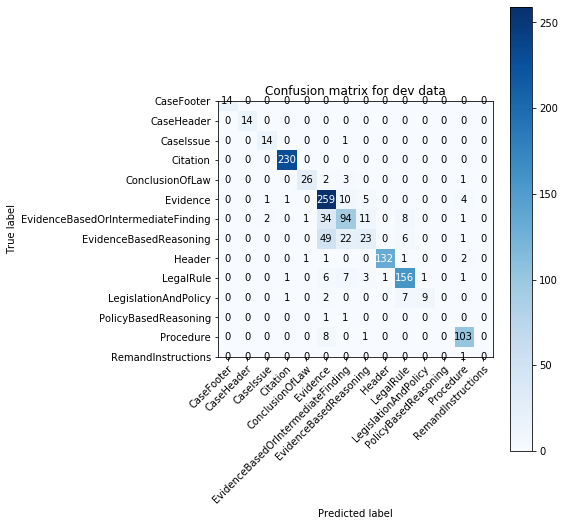

In [1210]:
plot_confusion_matrix(dev_span_types, clf_skl.predict(dev_tfidf_skl), classes=list(clf_skl.classes_),
                      title='Confusion matrix for dev data')
plt.show()

In [1211]:
print('TEST:\n'+classification_report(test_span_types,
                                      clf_skl.predict(test_tfidf_skl)))

TEST:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      1.00      1.00        14
                         CaseIssue       1.00      1.00      1.00        14
                          Citation       1.00      0.98      0.99       250
                   ConclusionOfLaw       0.93      0.70      0.80        37
                          Evidence       0.77      0.97      0.86       568
EvidenceBasedOrIntermediateFinding       0.61      0.50      0.55       169
            EvidenceBasedReasoning       0.34      0.12      0.18       115
                            Header       1.00      0.99      0.99       145
                         LegalRule       0.86      0.89      0.88       199
              LegislationAndPolicy       0.67      0.21      0.32        19
              PolicyBasedReasoning       0.00      0.00      0.00         2
     

/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Different algorithm + word embedding featurazation

In [53]:
clf_we = SVC(kernel='rbf') #best model for word embedding
# clf_we = LogisticRegression()
# clf_we = tree.DecisionTreeClassifier(max_depth=25)
# clf_we = GaussianNB()
# clf_we = RandomForestClassifier(n_estimators=400, max_depth=20)
clf_we = clf_we.fit(train_feature_vectors, train_span_types) 

In [54]:
print('TRAIN:\n'+classification_report(train_span_types, 
                                       clf_we.predict(train_feature_vectors)))
print('DEV:\n'+classification_report(dev_span_types,
                                      clf_we.predict(dev_feature_vectors)))

/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       0.99      0.97      0.98       115
                         CaseIssue       0.94      0.97      0.96       113
                          Citation       0.98      0.98      0.98      1950
                   ConclusionOfLaw       0.88      0.81      0.85       268
                          Evidence       0.81      0.94      0.87      3793
EvidenceBasedOrIntermediateFinding       0.67      0.56      0.61      1153
            EvidenceBasedReasoning       0.52      0.25      0.34       835
                            Header       0.99      0.99      0.99      1197
                         LegalRule       0.81      0.91      0.86      1567
              LegislationAndPolicy       0.70      0.15      0.25       137
              PolicyBasedReasoning       0.00      0.00      0.00        25
    

/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


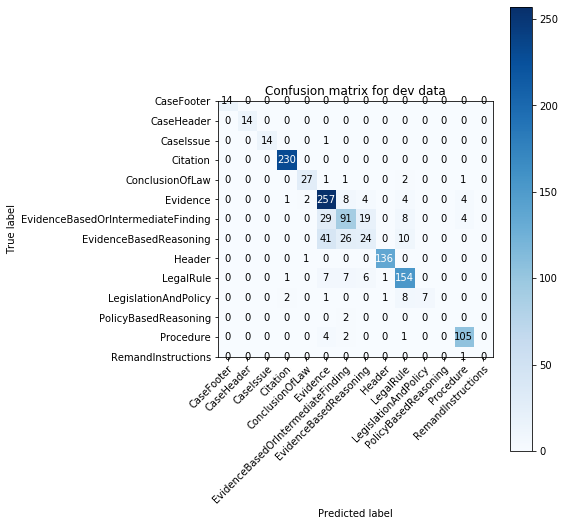

In [1431]:
plot_confusion_matrix(dev_span_types, clf_we.predict(dev_feature_vectors), classes=list(clf_we.classes_),
                      title='Confusion matrix for dev data')
plt.show()

In [1215]:
print('TEST:\n'+classification_report(test_span_types,
                                      clf_we.predict(test_feature_vectors)))

TEST:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      1.00      1.00        14
                         CaseIssue       0.93      1.00      0.97        14
                          Citation       0.98      0.98      0.98       250
                   ConclusionOfLaw       0.92      0.59      0.72        37
                          Evidence       0.80      0.97      0.88       568
EvidenceBasedOrIntermediateFinding       0.61      0.44      0.51       169
            EvidenceBasedReasoning       0.49      0.22      0.30       115
                            Header       0.99      0.99      0.99       145
                         LegalRule       0.82      0.90      0.86       199
              LegislationAndPolicy       0.80      0.21      0.33        19
              PolicyBasedReasoning       0.00      0.00      0.00         2
     

/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/i2dl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# Save the classifier model - TFIDF + SVM
file = open("./TFIDF_classifier.pickle", "wb")
pickle.dump(clf_skl, file)
file.close()

# Save the classifier model - word embedding + SVM
file = open("./WE_classifier.pickle", "wb")
pickle.dump(clf_we, file)
file.close()

## Phase 6: Error Analysis

In [16]:
documents_by_id = {d['_id']: d for d in documents}

In [17]:
def word_embedding_vectorization(todo_spans):
    span_todo_txts = [d['txt'] for d in todo_spans]
    tokenized_todo_txts = tokenize_span_txts(span_todo_txts)
    todo_token_numbers = get_token_number(tokenized_train_txts, tokenized_todo_txts)
    todo_span_positions = [d['position'] for d in todo_spans]
    
    return word_emb_featurization(span_todo_txts, todo_span_positions, todo_token_numbers)

# prediction errors analysis for TFIDF-based classifier: 
# referencing the function "prediction_errors" in the classifier workshop code
def prediction_errors_tfidf(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    eval_X = vectorizer.transform(eval_spans_txt).toarray()
    eval_y = np.array(eval_spans_labels)
    pred_y = clf.predict(eval_X)
        
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

# prediction errors analysis for word-embedding-based classifier
# referencing the function "prediction_errors" in the classifier workshop code
def prediction_errors_wd(clf, eval_spans,
                      select_true_label=None, 
                      select_pred_label=None):
    
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]    
    eval_X = word_embedding_vectorization(eval_spans)
    eval_y = np.array(eval_spans_labels)
    pred_y = clf.predict(eval_X)
    
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [20]:
eval_spans = random.sample(dev_span, 100)

In [21]:
print("prediction errors analysis for TFIDF-based classifier")
prediction_errors_tfidf(clf_skl,
                  eval_spans,
                  vectorizer,
                  select_pred_label='Evidence')

prediction errors analysis for TFIDF-based classifier
sentence # 57 / case 1003646.txt / @5636
pred: Evidence / true: EvidenceBasedReasoning
It was concluded that the Veteran 
had PTSD due to these stressors.

sentence # 59 / case 1420625.txt / @8126
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Initially, the Board notes the Veteran is service connected for both PTSD and CAD.

sentence # 60 / case 0811472.txt / @15657
pred: Evidence / true: EvidenceBasedReasoning
The veteran's Report of Discharge (DD Form 214) shows that he 
served in the Republic of Vietnam for 9 months; his military 
occupational specialty (MOS) was that of general vehicle 
repairman.

sentence # 61 / case 0739507.txt / @3729
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Therefore, the June 1977 rating decision is final 
based on the evidence then of record.

sentence # 83 / case 0811472.txt / @1063
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
1.  All notification and development

In [1349]:
print("prediction errors analysis for word-embedding-based classifier")
prediction_errors_wd(clf_we,
                  eval_spans,
                  select_pred_label='EvidenceBasedOrIntermediateFinding')

prediction errors analysis for word-embedding-based classifier
sentence # 1 / case 0721357.txt / @6486
pred: EvidenceBasedOrIntermediateFinding / true: EvidenceBasedReasoning
Concerning this, since the Board will conclude below that the 
preponderance of the evidence is against the veteran's claim 
for service connection, any question about the appropriate 
disability rating and effective date to be assigned is 
rendered moot.

sentence # 77 / case 0739507.txt / @7220
pred: EvidenceBasedOrIntermediateFinding / true: EvidenceBasedReasoning
This evidence thus deals directly 
with whether or not the veteran's diagnosed paranoid 
schizophrenia pre-existed, was aggravated by, or was incurred 
in active military service.

